# Script to Process Geospatial data to the Police Beat

Gabe Morrison

In [1]:
#library imports: 
import numpy as np
import pandas as pd
import geopandas as gpd
import geoplot

In [2]:
#The below function reads in the spatial data and sets a CRS. CRS (coordinate reference systems) determine 
# how spatial 3D data (because globe is round) get converted into a 2D plane. 
#The CRS I picked is ESPG 3435 which is targetted for Eastern Illinois.  

def read_spatial(path):
    '''
    Function to read spatial data and converts to ESPG 3435
    Input: path to the data file
    Output: a gpd object 
    '''
    file=gpd.read_file(path)
    file=file.to_crs("EPSG:3435")
    return file

In [3]:
beats = read_spatial("../raw_data/Boundaries - Police Beats (current).geojson")
l = read_spatial("../raw_data/CTA_RailStations")
bus = read_spatial("../raw_data/CTA_BusStops")
metra = read_spatial("../raw_data/Metra_Stations")
streets = read_spatial("../raw_data/Street Center Lines.geojson")

In [4]:
#Function to add point data to the beats polygon dataset
#Specifically, this function first performs a "spatial join" each point in the "other dataset" (ex bus station)
#gets the name of the police beat it is in in a new column ("beat_num")
#Then I group by and count the number of points in each beat and join that to the beat dataset


def join_to_beats(polygon_data, poly_unique_id, other_file, new_column_name):
    '''
    A function that creates a new beats gpd with an updated column 
        to count the number of points from the other_file 
    Inputs:
        polygon_data (gpd): the beats gpd (as a polygon)
        poly_unique_id (string): the unique identifier of the polygon spatial data
        other_file (gpd): another point-based gpd. The number of points in each beat will 
                    be added to the beats as a new column
        new_column_name (string): the name of the column to be added to the beats dataframe
    Output:
        the polygon_data dataframe updated with the new column
    Note: .size suggestion from here: https://stackoverflow.com/questions/19384532/get-statistics-for-each-group-such-as-count-mean-etc-using-pandas-groupby
    '''
    spatial_join = gpd.sjoin(other_file, 
                             polygon_data[[poly_unique_id, "geometry"]], 
                             how="inner", 
                             op='intersects')
    count = spatial_join.groupby(poly_unique_id).size().reset_index(name=new_column_name)
    updated_polygon_data = polygon_data.merge(count, on=poly_unique_id, how="left")
    updated_polygon_data[new_column_name].fillna(0, inplace=True)
    return updated_polygon_data

In [5]:
#Run above function to add point data to the beats
beats = join_to_beats(beats, "beat_num", l, "count_l_stops")
beats = join_to_beats(beats, "beat_num", bus, "count_bus_stops")
beats = join_to_beats(beats, "beat_num", metra, "count_metra_stops")

In [6]:
#Filter Out non-pedestrian Streets (ie highways):
#Syntax help: https://www.kite.com/python/answers/how-to-filter-a-pandas-dataframe-with-a-list-by-%60in%60-or-%60not-in%60-in-python
streets_do_not_want = ["ER", "EXPY", "HWY", "PKWY", "ORD", "XR", "TOLL"]
street_filter = ~streets.street_typ.isin(streets_do_not_want)
streets = streets[street_filter]

In [7]:
#Spatial operation to get all strings into exactly one polygon
#Help on overlay code here::https://stackoverflow.com/questions/60794994/geopandas-split-lines-at-intersection-with-polygons-retain-polygon-id-in-new
#Help with renaming after groupby: https://stackoverflow.com/questions/44416287/renaming-columns-after-group-by-and-sum-in-pandas-dataframe

#First: separate line segments so that they fall into exactly one police beat
#Second: same spatial join as above
#Third: Compute distance (in feet) of each segment
#Fourth/Fifth: Keep only the beat_num and distance columns
#Sixth:group by beat and sum all distances in the beat
#seventh:Add the column with the summarized distances back to the beat dataset


streets_separated = gpd.overlay(streets, beats, how="union", keep_geom_type=False).explode().reset_index(drop=True)
streets_separated = gpd.sjoin(streets_separated, 
                             beats[["beat_num", "geometry"]], 
                             how="inner", 
                             op='intersects')
streets_separated["distance"]= streets_separated["geometry"].length
streets_separated = streets_separated[["beat_num_left", "distance"]]
streets_separated.rename(columns={"beat_num_left":"beat_num"}, inplace=True)
streets_separated = streets_separated.groupby("beat_num").sum("distance").reset_index().rename(columns={'distance':'road_distance_ft'})
beats = beats.merge(streets_separated, how ="left", on="beat_num")

Goal of below section is to (1) create a crosswalk between blocks and beats and (2) use it to get total population (and maybe future data too) to the beat scale. 

The assumption is an equal distribution of population within a block which is obviously not a perfect assumption but super unreasonable either. I make this by subdividing the blocks to "sub_blocks" which are blocks divided by beats. That is, if a block is fully in a beat, the it remains the same as a sub_block. If a block is split into two beats, that block becomes two sub_blocks. I then compute the area of the sub_block/area of block (just 1 if the block is unsplit). Now, one can multiply this column by a population measure (ex Total population) and aggregate by block to estimate the measure by block. I write a function to do this.

In [63]:
blocks = read_spatial("../raw_data/Boundaries - Census Blocks - 2010.geojson")

In [64]:
#Create Crosswalk From Block to Beat:
#Read Block spatial data and population by block
#Then join the two
pop_10 = pd.read_csv("../raw_data/Population_by_2010_Census_Block.csv", 
                     dtype={"CENSUS BLOCK FULL":"object", "CENSUS BLOCK":"object"})
blocks = blocks.merge(pop_10, left_on="geoid10", right_on="CENSUS BLOCK FULL", how="left")

In [65]:
#Some data didn't match:
blocks.isna().sum()

statefp10             0
name10                0
blockce10             0
tract_bloc            0
geoid10               0
tractce10             0
countyfp10            0
geometry              0
CENSUS BLOCK         20
CENSUS BLOCK FULL    20
TOTAL POPULATION     20
dtype: int64

In [68]:
#Fill NA with the total average and select on population and id columns
#Select only columns of interest: 
blocks = blocks[["geoid10", "TOTAL POPULATION", "geometry"]]

#Fill NAs: 
mean_pop = blocks["TOTAL POPULATION"].mean()
blocks.fillna(mean_pop, inplace=True)

#Check nas filled:
blocks.isna().sum()


geoid10             0
TOTAL POPULATION    0
geometry            0
dtype: int64

In [75]:
blocks.shape

(46357, 4)

In [118]:
#Get full block area and area within each beat:

#Full block area
blocks["full_block_area"]=blocks.area

#Subdivide to in each beat:
blocks_exploded = gpd.overlay(blocks, beats, how="union", keep_geom_type=False).explode().reset_index(drop=True)


In [119]:
#Note that there are a number of sub_blocks here too 
blocks_exploded.isna().sum()

geoid10              8861
TOTAL POPULATION     8861
full_block_area      8861
beat                 9148
beat_num             9148
district             9148
sector               9148
count_l_stops        9148
count_bus_stops      9148
count_metra_stops    9148
road_distance_ft     9148
geometry                0
dtype: int64

In [121]:
blocks_exploded.shape

(81122, 12)

In [122]:
blocks_exploded["na_geoid"] = blocks_exploded["geoid10"].isna()
blocks_exploded["na_beat"]=blocks_exploded["beat"].isna()

<AxesSubplot:>

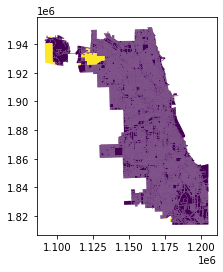

In [123]:
blocks_exploded.plot(column="na_geoid")

<AxesSubplot:>

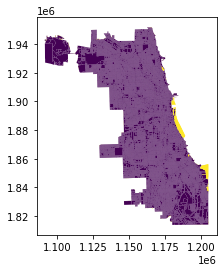

In [124]:
blocks_exploded.plot(column="na_beat")

Location of missing data: Some tracts are missing beat data if they are actually in Lake Michigan. Some beats are missing tract data if they are on the edges of Chicago (ie part of O'Hare or Norridge/Harrwood Heights). 

Solution: I throw all of this data out: we are looking for Chicago Police beats and these do not quality

In [125]:
blocks_exploded = blocks_exploded.dropna()

In [127]:
#Area of sub-block:
blocks_exploded["sub_block_area"]=blocks_exploded.area
#Percentage of area of full block:
blocks_exploded["pct_of_full_block"]=blocks_exploded["sub_block_area"]/blocks_exploded["full_block_area"]

/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [135]:
conversion_df = blocks_exploded[["geoid10", "beat_num", "pct_of_full_block"]]

,geoid10,beat_num,pct_of_full_block
0,170316903002010,0722,0.000234
1,170316809003007,0722,1.000000
2,170316809003013,0722,1.000000
3,170316809004001,0722,0.697993
4,170316809002005,0722,1.000000
...,...,...,...
63108,170319800001062,1655,0.011075
63109,170319800001010,1655,0.016442
63110,170319800001010,1651,0.040837
63111,170319800001010,1653,0.047456


In [154]:
def convert_block_to_beat(df_at_block, col_name):
    '''
    Function that converts data at the 2010 block scale to the Chicago beat scale 
    Note that this excludes census tracts not in beats as well as beats outside of Chicago prop
    Inputs:
        df_at_block(df): dataframe at the Chicago 2010 block scale
            Note: this df must have blocks identified with column geoid10
        col_name (string): the column of data to be converted to the beat scale
    Output:
        beats(df): the previous beats dataframe but with a new column for the aggregated data added
    '''
    df_at_block=df_at_block[["geoid10", col_name]]
    block_df = pd.merge(conversion_df, df_at_block, how="left", on="geoid10")
    block_df[col_name]=block_df["pct_of_full_block"] * block_df[col_name]
    
    beats_df = block_df.groupby("beat_num").agg({col_name:"sum"})
    beats2 = pd.merge(beats, beats_df, how = "left", on = "beat_num")
    return beats2

In [161]:
beats = convert_block_to_beat(blocks, "TOTAL POPULATION")

<AxesSubplot:>

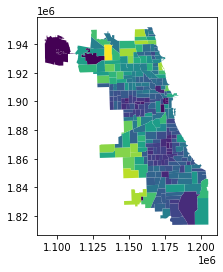

In [162]:
beats.plot(column="TOTAL POPULATION")

(275, 1)

(277, 9)